# Overfitting demo

## Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [1]:
import pandas as pd
import math
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model

Create random values for x in interval [0,1)

In [2]:
random.seed(98103)
n = 30
x = pd.Series([random.random() for i in range(n)])
x.sort()

C:\Users\Dejucoder\Miniconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


Compute y

In [3]:
y = x.apply(lambda x: math.sin(4*x))

Add random Gaussian noise to y

In [4]:
random.seed(1)
e = pd.Series([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into an SFrame to manipulate later

In [5]:
data = pd.DataFrame()
data['X1']=x
data['Y']=y
data

,X1,Y
25,0.039579,0.499085
2,0.041568,0.187619
26,0.072432,0.517774
16,0.150289,0.672500
5,0.161334,0.611912
15,0.191956,0.873905
11,0.232834,0.497761
0,0.259901,1.291599
13,0.380146,0.977159
27,0.432445,1.030213


### Create a function to plot the data, since we'll do it many times

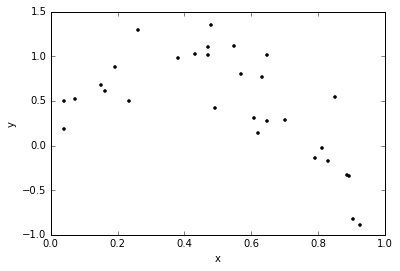

In [6]:
def plot_data(data):    
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [7]:
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [8]:
def polynomial_regression(data, deg):
    model = linear_model.LinearRegression()
    features=[]
    for i in range(1,deg+1) : features.append('X'+str(i))
    model.fit(polynomial_features(data,deg)[features], data['Y'])
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [9]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coef_)
    print(deg)
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = pd.DataFrame()
    x_pred['X1'] = [i/200.0 for i in range(200)]
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way :)

In [10]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coef_)
    print(deg)
    # Get learned parameters as a list
    w = list(model.coef_)
    w.insert(0, model.intercept_)

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print ('Learned polynomial for degree ' + str(deg) + ':')
    w.reverse()
    print (np.poly1d(w))

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [11]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [12]:
print_coefficients(model)

2
Learned polynomial for degree 2:
        2
-5.479 x + 4.144 x + 0.1984


Form and plot our predictions along a grid of x values:

2


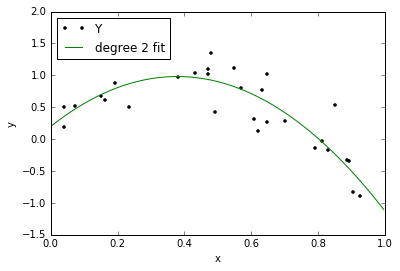

In [13]:
plot_poly_predictions(data,model)

## Fit a degree-4 polynomial

4
Learned polynomial for degree 4:
       4         3         2
-3.29 x + 7.153 x - 10.65 x + 5.503 x + 0.114
4


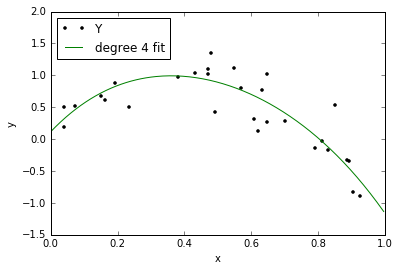

In [14]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)

## Fit a degree-16 polynomial

In [15]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

16
Learned polynomial for degree 16:
           16             15            14             13
1.073e+09 x  - 8.554e+09 x  + 3.11e+10 x  - 6.829e+10 x 
              12             11             10             9
 + 1.011e+11 x  - 1.065e+11 x  + 8.243e+10 x  - 4.758e+10 x
              8             7             6             5            4
 + 2.061e+10 x - 6.688e+09 x + 1.613e+09 x - 2.843e+08 x + 3.57e+07 x
              3             2
 - 3.067e+06 x + 1.684e+05 x - 5212 x + 67.82


###Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

16


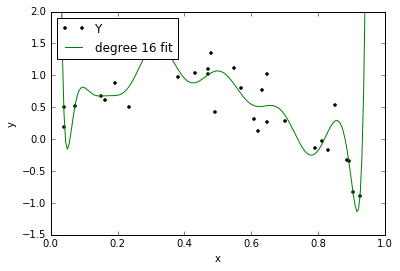

In [16]:
plot_poly_predictions(data,model)

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

# 

# 

 # 

 # 

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [17]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = linear_model.Ridge(alpha=l2_penalty)
    features=[]
    for i in range(1,deg+1) : features.append('X'+str(i))
    model.fit(polynomial_features(data,deg)[features], data['Y'])
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [18]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

16
Learned polynomial for degree 16:
           16             15             14             13
9.583e+08 x  - 7.655e+09 x  + 2.789e+10 x  - 6.138e+10 x 
              12             11             10             9
 + 9.103e+10 x  - 9.617e+10 x  + 7.459e+10 x  - 4.316e+10 x
              8             7             6            5             4
 + 1.874e+10 x - 6.099e+09 x + 1.475e+09 x - 2.61e+08 x + 3.293e+07 x
              3            2
 - 2.844e+06 x + 1.57e+05 x - 4889 x + 63.97


16


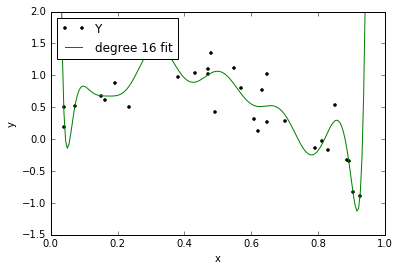

In [19]:
plot_poly_predictions(data,model)

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [20]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

16
Learned polynomial for degree 16:
         16            15          14           13           12
-0.0083 x  - 0.009194 x  - 0.0102 x  - 0.01132 x  - 0.01258 x 
            11           10           9           8           7
 - 0.01399 x  - 0.01558 x  - 0.01736 x - 0.01936 x - 0.02156 x
            6           5           4          3           2
 - 0.02395 x - 0.02644 x - 0.02879 x - 0.0304 x - 0.02978 x - 0.02294 x + 0.5058


16


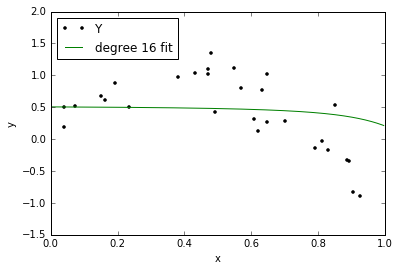

In [21]:
plot_poly_predictions(data,model)

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
16
Learned polynomial for degree 16:
           16             15             14             13
9.583e+08 x  - 7.655e+09 x  + 2.789e+10 x  - 6.138e+10 x 
              12             11             10             9
 + 9.103e+10 x  - 9.617e+10 x  + 7.459e+10 x  - 4.316e+10 x
              8             7             6            5             4
 + 1.874e+10 x - 6.099e+09 x + 1.475e+09 x - 2.61e+08 x + 3.293e+07 x
              3            2
 - 2.844e+06 x + 1.57e+05 x - 4889 x + 63.97


16
lambda = 1.00e-10
16
Learned polynomial for degree 16:
      16        15        14         13        12        11         10
6461 x  - 6221 x  - 5652 x  + 66.42 x  + 4508 x  + 4452 x  + 600.6 x 
         9        8         7        6         5        4        3
 - 3317 x - 3435 x + 392.3 x + 3165 x + 337.5 x - 2286 x + 1157 x
          2
 - 232.3 x + 21.93 x - 0.231


16
lambda = 1.00e-06
16
Learned polynomial for degree 16:
       16         15         14         13         12    

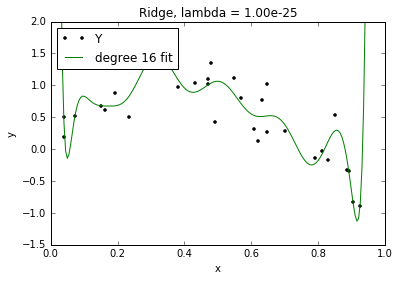

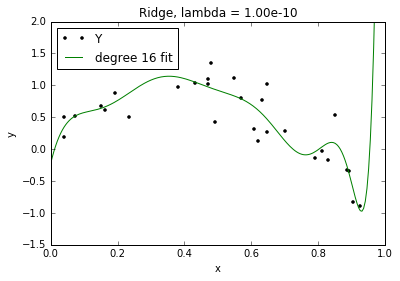

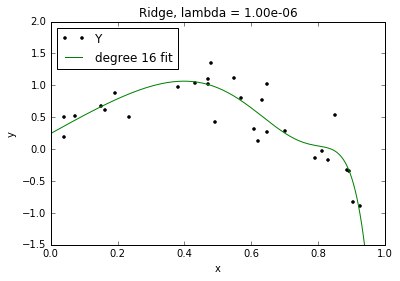

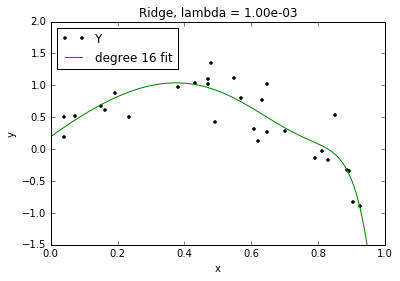

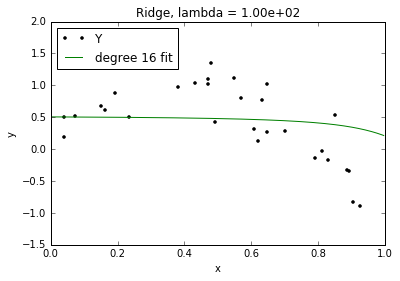

In [22]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print ('lambda = %.2e' % l2_penalty)
    print_coefficients(model)
    print ('\n')
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [30]:
# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data,num_folds)
    
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            # train model
            model = graphlab.linear_regression.create(train_set,target='Y', 
                                                      l2_penalty=l2_penalty,
                                                      validation_set=None,verbose=False)
            
            # predict on validation set 
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
        
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse,best_l2_penalty

Run LOO cross validation for "num" values of lambda, on a log scale

In [31]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse,best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

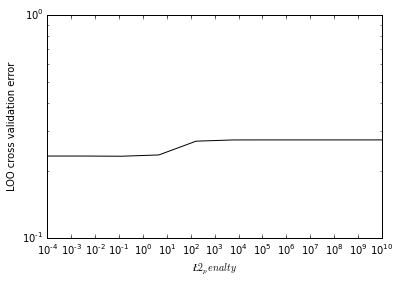

In [32]:
plt.plot(l2_penalty_values,l2_penalty_mse,'k-')
plt.xlabel('$\L2_penalty$')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [33]:
best_l2_penalty

0.12915496650148839

In [34]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree 16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


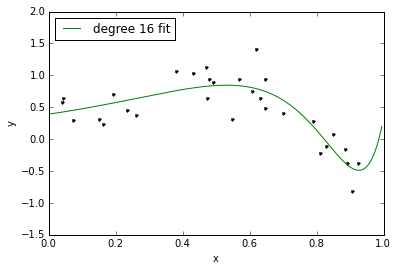

In [35]:
plot_poly_predictions(data,model)

# 

# 

# 

# 

# Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda (here called "L1_penalty").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [23]:
def polynomial_lasso_regression(data, deg, l1_penalty):
    model = linear_model.Lasso(alpha=l1_penalty)
    features=[]
    for i in range(1,deg+1) : features.append('X'+str(i))
    model.fit(polynomial_features(data,deg)[features], data['Y'])
    return model

## Explore the lasso solution as a function of a few different penalty strengths

We refer to lambda in the lasso case below as "l1_penalty"

l1_penalty = 1.000000e-04
number of nonzeros = 10
16
Learned polynomial for degree 16:
        16          15     14     13          9         8         7
-6.172 x  - 0.5894 x  - 0 x  - 0 x  + 0.2127 x + 1.399 x + 2.324 x
          6     5     4         3         2
 + 1.925 x - 0 x - 0 x - 3.225 x - 5.151 x + 4.825 x + 0.1209


16
l1_penalty = 1.000000e-02
number of nonzeros = 3
16
Learned polynomial for degree 16:
        5          4     3     2
-1.908 x - 0.1002 x - 0 x - 0 x + 0.7769


16
l1_penalty = 1.000000e-01
number of nonzeros = 2
16
Learned polynomial for degree 16:
         3     2
-0.2306 x - 0 x - 0 x + 0.5119


16
l1_penalty = 1.000000e+01
number of nonzeros = 1
16
Learned polynomial for degree 16:
 
0.4527


16


C:\Users\Dejucoder\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


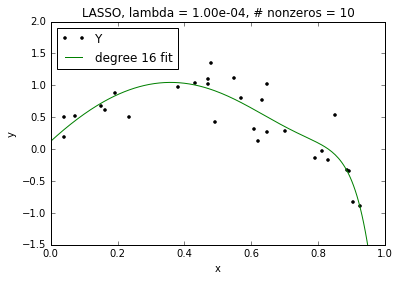

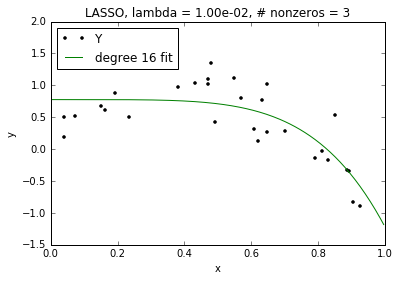

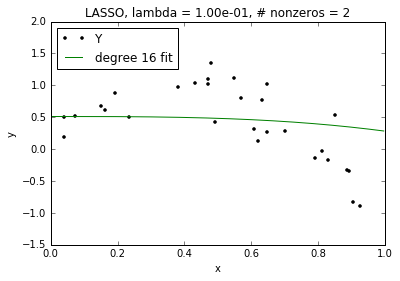

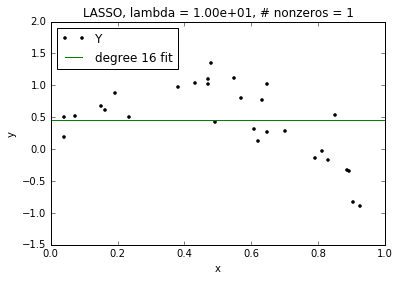

In [27]:
for l1_penalty in [0.0001, 0.01, 0.1, 10]:
    model = polynomial_lasso_regression(data, deg=16, l1_penalty=l1_penalty)
    print ('l1_penalty = %e' % l1_penalty)
    nonzeros = 0
    if model.intercept_!=0.0 : nonzeros+=1
    for coef in model.coef_ :
        if coef!=0.0 : nonzeros+=1
    print ('number of nonzeros = %d' % (nonzeros))
    print_coefficients(model)
    print ('\n')
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (l1_penalty, nonzeros))

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.